# Aperçu rapide des données

## Importations

In [1]:
import numpy as np
import pandas as pd 

import os
import time

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import gc

## Chargement des fichiers

In [4]:
app_train = pd.read_csv("csv/application_train.csv")
print("Dimensions du jeu d'entraînement :", app_train.shape)
app_train.head()

Dimensions du jeu d'entraînement : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_test = pd.read_csv("csv/application_test.csv")
print("Dimensions du jeu de test :", app_test.shape)
app_test.head()

Dimensions du jeu de test : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Distribution de la cible

In [6]:
target_count = app_train["TARGET"].value_counts()
print(target_count)

TARGET
0    282686
1     24825
Name: count, dtype: int64


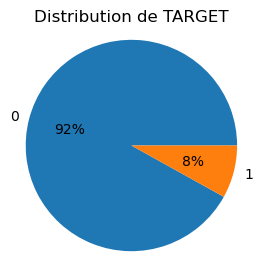

In [7]:
target_count.plot.pie(figsize = (3, 3), autopct = "%1.0f%%")
plt.axis("equal")
plt.ylabel("")
plt.title("Distribution de TARGET")
plt.show()

## Valeurs manquantes

In [8]:
def missing_values_table(df) :

    count = df.isnull().sum()
    percentage = 100 * df.isnull().sum() / len(df)
        
    table = pd.concat([count, percentage], axis = 1)
    table = table.rename(columns = {0 : "Missing Values", 1 : "Percentage"})
    table = table.loc[table["Missing Values"] != 0]
    table = table.sort_values("Percentage", ascending = False).round(1)

    print("Valeurs manquantes dans", len(table), "des", len(df), "colonnes.")
    
    return table

In [9]:
missing_values_table(app_train).head(10)

Valeurs manquantes dans 67 des 307511 colonnes.


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## Encodage des variables catégorielles

In [10]:
print("Nombre de colonnes par type :")
app_train.dtypes.value_counts()

Nombre de colonnes par type :


float64    65
int64      41
object     16
Name: count, dtype: int64

In [11]:
print("Cardinalité des variables catégorielles :")
app_train.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

Cardinalité des variables catégorielles :


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [12]:
label_encoder = LabelEncoder()

print("Application du Label Encoder :")

for column in app_train.columns :
    if app_train[column].dtype == "object" :
        if len(list(app_train[column].unique())) <= 2 :
            label_encoder.fit(app_train[column])
            app_train[column] = label_encoder.transform(app_train[column])
            app_test[column] = label_encoder.transform(app_test[column])
            print(column)

Application du Label Encoder :
NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY


In [13]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Dimensions du jeu d'entraînement :", app_train.shape)
print("Dimensions du jeu de test :", app_test.shape)

Dimensions du jeu d'entraînement : (307511, 243)
Dimensions du jeu de test : (48744, 239)


In [14]:
train_labels = app_train["TARGET"]
app_train, app_test = app_train.align(app_test, join = "inner", axis = 1)
app_train["TARGET"] = train_labels

print("Dimensions du jeu d'entraînement :", app_train.shape)
print("Dimensions du jeu de test :", app_test.shape)

Dimensions du jeu d'entraînement : (307511, 240)
Dimensions du jeu de test : (48744, 239)


# Analyse exploratoire

## Anomalies

In [15]:
(app_train["DAYS_BIRTH"] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [16]:
app_train["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
def plot_histogram(df, feature, label, bins, figsize) :

    df[feature].plot.hist(
        figsize = figsize,
        title = f"Distribution de {feature}",
        edgecolor = "k",
        bins = bins
    )

    plt.xlabel(label)
    plt.ylabel("Effectif")
    plt.show()

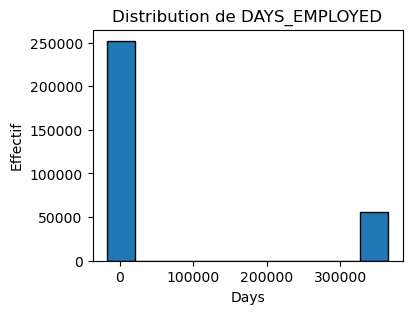

In [18]:
plot_histogram(app_train, "DAYS_EMPLOYED", "Days", 10, (4, 3))

In [19]:
anom = app_train[app_train["DAYS_EMPLOYED"] > 40000]
non_anom = app_train[app_train["DAYS_EMPLOYED"] <= 40000]

default_anom = round(100 * anom["TARGET"].mean(), 1)
default_non_anom = round(100 * non_anom["TARGET"].mean(), 1)

print("Nombre d'entrées anormales dans app_train :", len(anom), "sur", len(app_train))
print("Défaut de remboursement pour les entrées normales :", default_non_anom, "%")
print("Défaut de remboursement pour les entrées anormales :", default_anom, "%")

Nombre d'entrées anormales dans app_train : 55374 sur 307511
Défaut de remboursement pour les entrées normales : 8.7 %
Défaut de remboursement pour les entrées anormales : 5.4 %


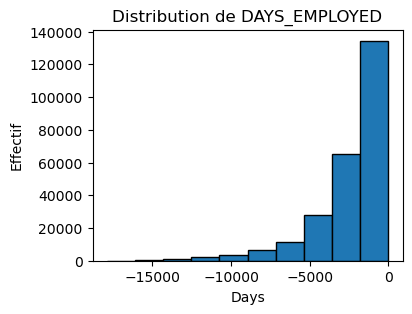

In [20]:
app_train["DAYS_EMPLOYED_ANOM"] = (app_train["DAYS_EMPLOYED"] > 40000)
app_train.loc[app_train["DAYS_EMPLOYED"] > 40000, "DAYS_EMPLOYED"] = np.nan

plot_histogram(app_train, "DAYS_EMPLOYED", "Days", 10, (4, 3))

In [21]:
app_test["DAYS_EMPLOYED_ANOM"] = (app_test["DAYS_EMPLOYED"] > 40000)
anom_count = app_test["DAYS_EMPLOYED_ANOM"].sum()

app_test.loc[app_test["DAYS_EMPLOYED"] > 40000, "DAYS_EMPLOYED"] = np.nan

print("Nombre d'entrées anormales dans app_test :", anom_count, "sur", len(app_test))

Nombre d'entrées anormales dans app_test : 9274 sur 48744


## Corrélations

In [22]:
start_time = time.time()

correlations = app_train.corr()["TARGET"]

duration = round(time.time() - start_time, 3)
print("Temps pour calculer les corrélations :", duration, "secondes")

Temps pour calculer les corrélations : 34.99 secondes


In [23]:
print("Meilleurs correlations positives")
print(correlations.sort_values(ascending = False).head(10))

print("Meilleurs correlations négatives")
print(correlations.sort_values().head(10))

Meilleurs correlations positives
TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
NAME_INCOME_TYPE_Working       0.057481
DAYS_LAST_PHONE_CHANGE         0.055218
CODE_GENDER_M                  0.054713
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64
Meilleurs correlations négatives
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, d

## Impact de l'âge sur le remboursement

In [24]:
age_data = app_train[["TARGET", "DAYS_BIRTH"]].copy()
age_data["DAYS_BIRTH"] = abs(age_data["DAYS_BIRTH"])

age_corr = age_data["DAYS_BIRTH"].corr(age_data["TARGET"])
print("Corrélation entre l'âge et la cible :", age_corr)

Corrélation entre l'âge et la cible : -0.07823930830982692


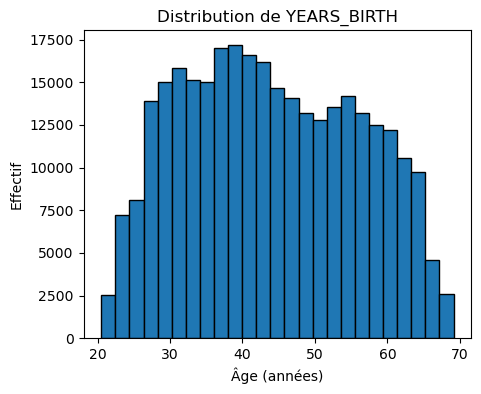

In [25]:
age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / 365
plot_histogram(age_data, "YEARS_BIRTH", "Âge (années)", 25, (5, 4))

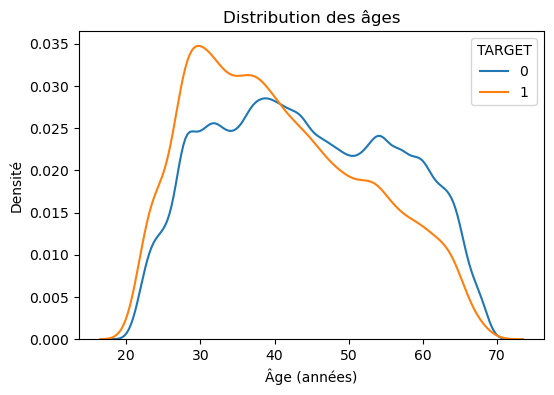

In [26]:
plt.figure(figsize = (6, 4))

sns.kdeplot(age_data.loc[age_data["TARGET"] == 0, "YEARS_BIRTH"], label = "0")
sns.kdeplot(age_data.loc[age_data["TARGET"] == 1, "YEARS_BIRTH"], label = "1")

plt.xlabel("Âge (années)")
plt.ylabel("Densité")
plt.title("Distribution des âges")
plt.legend(title = "TARGET")
plt.show()

In [27]:
age_data["YEARS_BINNED"] = pd.cut(age_data["YEARS_BIRTH"],
                                  bins = np.linspace(20, 70, num = 11))

age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [28]:
age_groups = age_data.groupby("YEARS_BINNED").mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


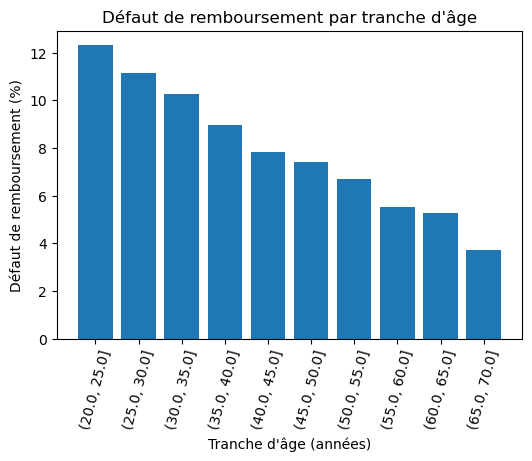

In [29]:
plt.figure(figsize = (6, 4))

plt.bar(age_groups.index.astype(str), 100 * age_groups["TARGET"])

plt.xticks(rotation = 75)
plt.xlabel("Tranche d'âge (années)")
plt.ylabel("Défaut de remboursement (%)")
plt.title("Défaut de remboursement par tranche d'âge")
plt.show()

## Sources extérieures

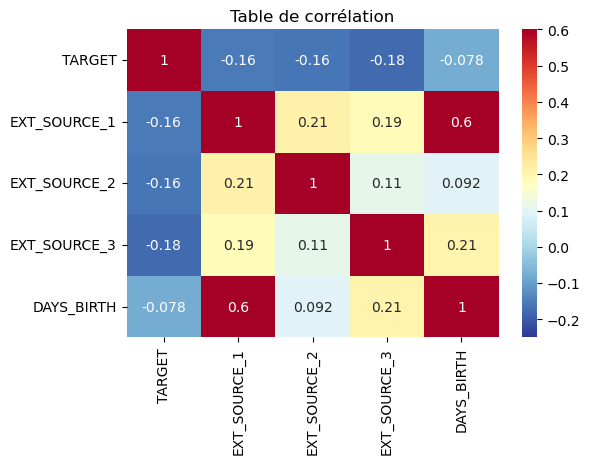

In [30]:
ext_data = app_train[["TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH"]]
ext_data["DAYS_BIRTH"] = abs(ext_data["DAYS_BIRTH"])

plt.figure(figsize = (6, 4))
sns.heatmap(ext_data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title("Table de corrélation")
plt.show()

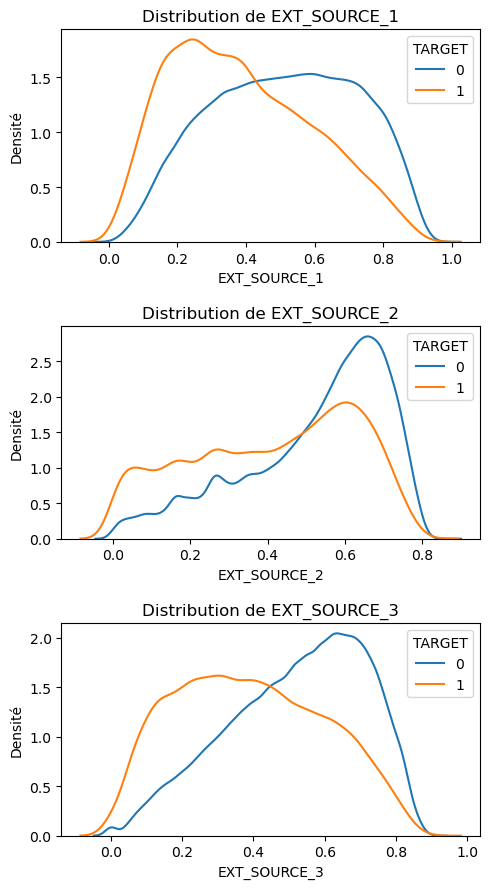

In [31]:
plt.figure(figsize = (5, 9))

for i, source in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]) :

    plt.subplot(3, 1, i + 1)
    
    sns.kdeplot(ext_data.loc[ext_data["TARGET"] == 0, source], label = "0")
    sns.kdeplot(ext_data.loc[ext_data["TARGET"] == 1, source], label = "1")
    
    plt.title(f"Distribution de {source}")
    plt.xlabel(source)
    plt.ylabel("Densité")
    plt.legend(title = "TARGET")
    
plt.tight_layout(h_pad = 1.5)

## Pair plots

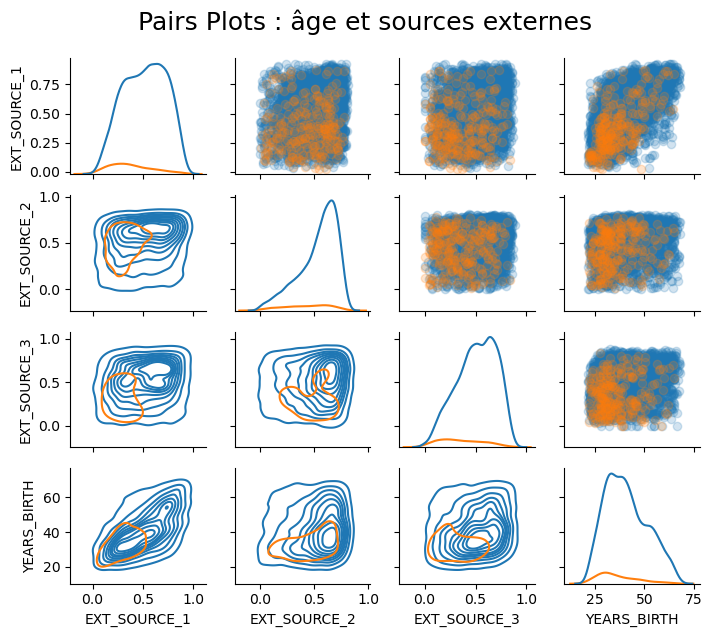

In [32]:
def corr_func(x, y, **kwargs) :
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy = (.2, .8), xycoords = ax.transAxes, size = 20)

plot_data = ext_data.drop(columns = ["DAYS_BIRTH"]).copy()
plot_data["YEARS_BIRTH"] = age_data["YEARS_BIRTH"]
plot_data = plot_data.dropna().loc[:10000, :]

grid = sns.PairGrid(data = plot_data, diag_sharey = False, hue = "TARGET",
                    vars = [x for x in list(plot_data.columns) if x != "TARGET"],
                    height = 1.5, aspect = 1.2)

grid.map_upper(plt.scatter, alpha = 0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle("Pairs Plots : âge et sources externes", size = 18, y = 1.05)
plt.show()

# Feature engineering

In [33]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain["CREDIT_INCOME_PERCENT"] = app_train_domain["AMT_CREDIT"] / app_train_domain["AMT_INCOME_TOTAL"]
app_train_domain["ANNUITY_INCOME_PERCENT"] = app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_INCOME_TOTAL"]
app_train_domain["CREDIT_TERM"] = app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_CREDIT"]
app_train_domain["DAYS_EMPLOYED_PERCENT"] = app_train_domain["DAYS_EMPLOYED"] / app_train_domain["DAYS_BIRTH"]

app_test_domain["CREDIT_INCOME_PERCENT"] = app_test_domain["AMT_CREDIT"] / app_test_domain["AMT_INCOME_TOTAL"]
app_test_domain["ANNUITY_INCOME_PERCENT"] = app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_INCOME_TOTAL"]
app_test_domain["CREDIT_TERM"] = app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_CREDIT"]
app_test_domain["DAYS_EMPLOYED_PERCENT"] = app_test_domain["DAYS_EMPLOYED"] / app_test_domain["DAYS_BIRTH"]

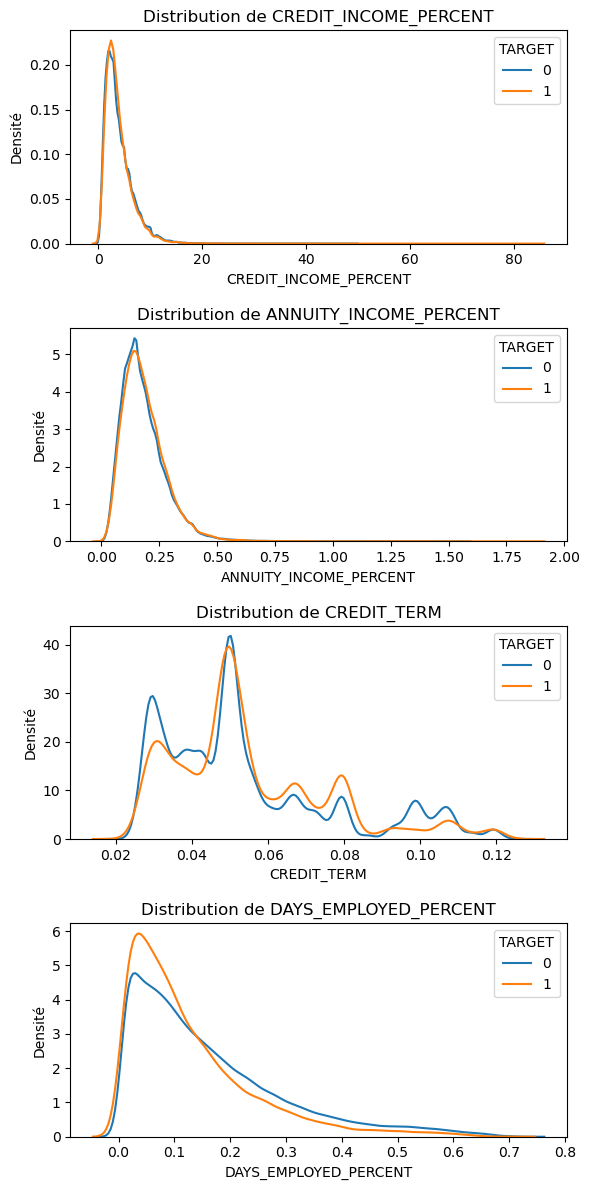

In [34]:
plt.figure(figsize = (6, 12))

features = ["CREDIT_INCOME_PERCENT", "ANNUITY_INCOME_PERCENT", "CREDIT_TERM", "DAYS_EMPLOYED_PERCENT"]

for i, feature in enumerate(features) :
    
    plt.subplot(4, 1, i + 1)
    
    sns.kdeplot(app_train_domain.loc[app_train_domain["TARGET"] == 0, feature], label = "0")
    sns.kdeplot(app_train_domain.loc[app_train_domain["TARGET"] == 1, feature], label = "1")

    plt.title(f"Distribution de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Densité")
    plt.legend(title = "TARGET")
    
plt.tight_layout(h_pad = 1.5)

# Apprentissage automatique

## Baseline

In [35]:
X_train = app_train.drop(columns = ["TARGET"])
y_train = app_train["TARGET"].copy()
X_test = app_test.copy()

feature_names = list(X_train.columns)

print("Dimensions du jeu d'entraînement :", X_train.shape)
print("Dimensions du jeu de test :", X_test.shape)

Dimensions du jeu d'entraînement : (307511, 240)
Dimensions du jeu de test : (48744, 240)


In [36]:
start_time = time.time()

imputer = SimpleImputer(strategy = "median")
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Temps de traitement :", round(time.time() - start_time, 3), "secondes")

Temps de traitement : 11.268 secondes


In [37]:
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(X_train, train_labels)

LogisticRegression(C=0.0001)

In [38]:
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

## Random Forest

In [39]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [40]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({
    "feature" : feature_names,
    "importance" : feature_importance_values})

predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


In [41]:
domain_features_train = app_train_domain.drop(columns = "TARGET")
domain_features_test = app_test_domain.copy()

domain_feature_names = list(domain_features_train.columns)

print("Dimensions du jeu d'entraînement :", domain_features_train.shape)
print("Dimensions du jeu de test :", domain_features_test.shape)

Dimensions du jeu d'entraînement : (307511, 244)
Dimensions du jeu de test : (48744, 244)


In [42]:
start_time = time.time()

imputer = SimpleImputer(strategy = "median")
domain_features_train = imputer.fit_transform(domain_features_train)
domain_features_test = imputer.transform(domain_features_test)

scaler = MinMaxScaler(feature_range = (0, 1))
domain_features_train = scaler.fit_transform(domain_features_train)
domain_features_test = scaler.transform(domain_features_test)

print("Temps de traitement :", round(time.time() - start_time, 3), "secondes")

Temps de traitement : 10.968 secondes


In [43]:
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest_domain.fit(domain_features_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.6s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [44]:
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({
    "feature": domain_feature_names,
    "importance": feature_importance_values_domain
})

predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


In [45]:
def plot_feature_importances(df, nb_features, title) :
    
    df = df.sort_values("importance", ascending = False).reset_index()
    df["importance_normalized"] = df["importance"] / df["importance"].sum()

    plt.figure(figsize = (6, 4))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:nb_features]))), 
            df["importance_normalized"].head(nb_features), 
            align = "center",
            edgecolor = "k")
    
    ax.set_yticks(list(reversed(list(df.index[:nb_features]))))
    ax.set_yticklabels(df["feature"].head(nb_features))
    ax.tick_params(axis = "y", labelsize = 8)
    
    plt.xlabel("Importance normalisée")
    plt.title(title, size = 14)
    plt.show()
    
    return df

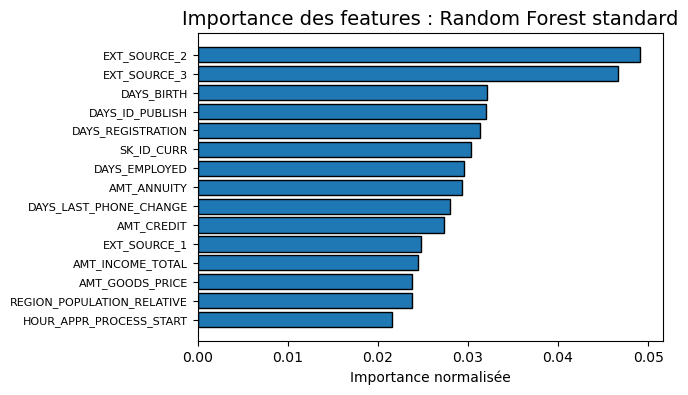

In [46]:
title = "Importance des features : Random Forest standard"
feature_importances_sorted = plot_feature_importances(feature_importances, 15, title)

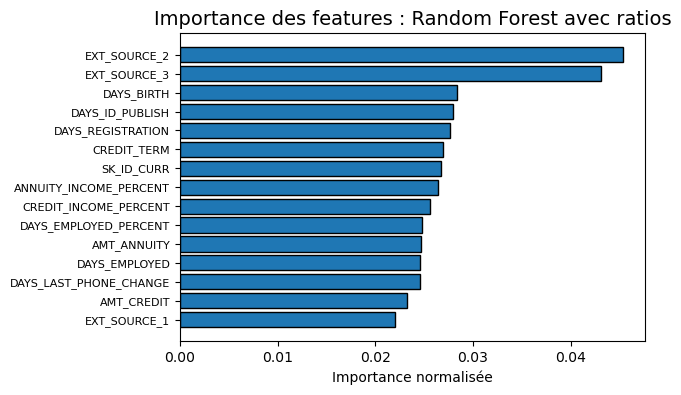

In [47]:
title = "Importance des features : Random Forest avec ratios"
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain, 15, title)

## LightGBM

In [48]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices)
                  #early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [49]:
submission, fi, metrics = model(app_train, app_test)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11473
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19863, number of negative: 226146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11511
[LightGBM] [Info] Number of data po

In [57]:
print("Métrique AUROC : LightGBM standard")
metrics

Métrique AUROC : LightGBM standard


,fold,train,valid
0,0,0.998964,0.706788
1,1,0.998863,0.710972
2,2,0.998852,0.705980
3,3,0.998963,0.708983
4,4,0.998877,0.711455
5,overall,0.998904,0.708833


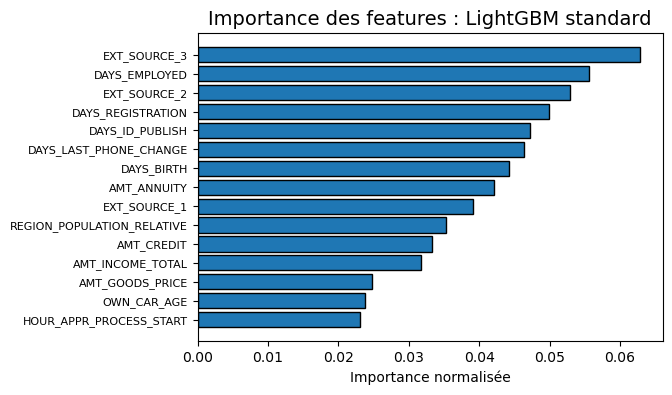

In [58]:
title = "Importance des features : LightGBM standard"
fi_sorted = plot_feature_importances(fi, 15, title)

In [59]:
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12493
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19863, number of negative: 226146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12531
[LightGBM] [Info] Number of data po

In [60]:
print("Métrique AUROC : LightGBM avec ratios")
metrics_domain

Métrique AUROC : LightGBM avec ratios


,fold,train,valid
0,0,0.999256,0.713775
1,1,0.999361,0.720872
2,2,0.999253,0.714364
3,3,0.999285,0.715660
4,4,0.999379,0.719659
5,overall,0.999307,0.716856


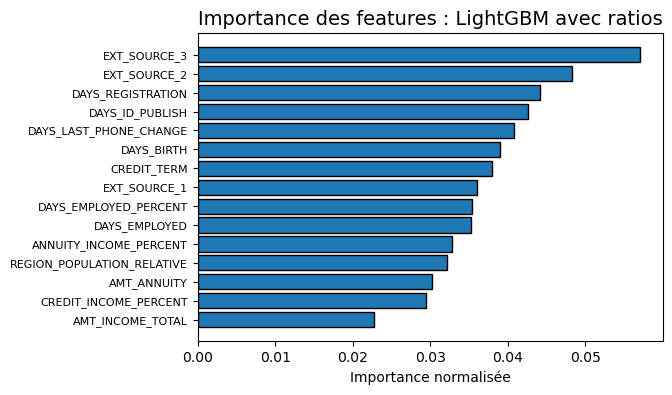

In [61]:
title = "Importance des features : LightGBM avec ratios"
fi_sorted = plot_feature_importances(fi_domain, 15, title)